In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import re
import pickle

# Importing/Cleaning Raw Pitch and Stealing Data

In [1124]:
raw = pd.read_csv('stealingData2.csv',index_col=0)

In [1125]:
extra = pd.read_csv('stealingDataExtra.csv',index_col=0)

In [1126]:
raw = raw.dropna(axis = 0)

In [1127]:
raw = raw.append(extra)

/var/folders/m6/z_7vpd8x7j79s4b0lm1vxb280000gn/T/ipykernel_26144/2145178511.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [1128]:
raw['runner'] = raw['rob1_outcomeDescription'].str.split().str[:2].str.join(sep = ' ')

In [1129]:
raw.head(2)

,year,awayTeamName,homeTeamName,inningHalf,outcomeDescription,atBatEventType,hitterBatHand,pitcherThrowHand,pitcherId,pitcherFirstName,...,pitchType,pitchTypeDescription,pitchSpeed,pitchZone,rob1_outcomeId,rob1_outcomeDescription,awayFielder2,homeFielder2,is_wild_pitch,runner
0,2016,Indians,Blue Jays,BOT,Dirt Ball,PITCH,R,R,e3096bc2-0ed0-4783-b43a-5f1ab7d563ba,Trevor,...,CU,Curveball,78,12,SB2,Junior Lake steals second.,879db845-963e-4169-ae9c-4cd80406a322,e9fd69cd-c5df-4738-92c2-7e4ce2f4a0f4,0.0,Junior Lake
1,2016,Indians,Blue Jays,BOT,Strike Swinging,PITCH,R,R,e3096bc2-0ed0-4783-b43a-5f1ab7d563ba,Trevor,...,FA,Fastball,95,10,SB2,Kevin Pillar steals second.,879db845-963e-4169-ae9c-4cd80406a322,e9fd69cd-c5df-4738-92c2-7e4ce2f4a0f4,0.0,Kevin Pillar


In [1130]:
raw.shape

(2854, 21)

In [1131]:
q = pd.read_csv('stealingDataExtra2.csv',index_col=0)
x = q['description'].str.find('.') + 2

In [1132]:
new = []
ind = 0
for i in q['description']:
    
    new.append(i[x[ind]:])
    ind +=1


In [1133]:
q['description'] = new

In [1134]:
q['runner'] = q['description'].str.split().str[:2].str.join(sep = ' ')

In [1135]:
NEWrob1 = []
for index,row in q.iterrows():
    if 'caught' in row['description']:
        NEWrob1.append(0)
    else:
         NEWrob1.append(1)

In [1136]:
q['rob1_outcomeId'] =  NEWrob1

In [1137]:
q = q.drop('description', axis = 1)

In [1138]:
raw = raw.append(q)

/var/folders/m6/z_7vpd8x7j79s4b0lm1vxb280000gn/T/ipykernel_26144/3806245728.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [1139]:
raw.shape

(4895, 21)

In [1140]:
raw.rob1_outcomeId.unique()

array(['SB2', 'CS2', 'POCS2', 'CS3', 'SB3', 'SB2E3', 0, 1], dtype=object)

In [1141]:
raw = raw[((raw['rob1_outcomeId'] == 'SB2') |  (raw['rob1_outcomeId'] == 'CS2') ) & ((raw['pitchSpeed'] == 0) == False) & ((raw['pitchType'] == 'FO') == False)]

In [1142]:
raw.shape

(2839, 21)

In [1143]:
raw.rob1_outcomeId.unique()

array(['SB2', 'CS2'], dtype=object)

In [1144]:
raw = raw.reset_index(drop=True)

In [1145]:
raw.shape

(2839, 21)

In [1147]:
raw['catcherID'] = np.ones(raw.shape[0])

In [1148]:
for index,row in raw.iterrows():
    if raw.loc[index,'inningHalf'] == 'TOP':
        raw.loc[index,'catcherID'] = raw.loc[index,'homeFielder2']
    else:
        raw.loc[index,'catcherID'] = raw.loc[index,'awayFielder2']

In [1150]:
raw.head(2)

,year,awayTeamName,homeTeamName,inningHalf,outcomeDescription,atBatEventType,hitterBatHand,pitcherThrowHand,pitcherId,pitcherFirstName,...,pitchTypeDescription,pitchSpeed,pitchZone,rob1_outcomeId,rob1_outcomeDescription,awayFielder2,homeFielder2,is_wild_pitch,runner,catcherID
0,2016,Indians,Blue Jays,BOT,Dirt Ball,PITCH,R,R,e3096bc2-0ed0-4783-b43a-5f1ab7d563ba,Trevor,...,Curveball,78,12,SB2,Junior Lake steals second.,879db845-963e-4169-ae9c-4cd80406a322,e9fd69cd-c5df-4738-92c2-7e4ce2f4a0f4,0.0,Junior Lake,879db845-963e-4169-ae9c-4cd80406a322
1,2016,Indians,Blue Jays,BOT,Strike Swinging,PITCH,R,R,e3096bc2-0ed0-4783-b43a-5f1ab7d563ba,Trevor,...,Fastball,95,10,SB2,Kevin Pillar steals second.,879db845-963e-4169-ae9c-4cd80406a322,e9fd69cd-c5df-4738-92c2-7e4ce2f4a0f4,0.0,Kevin Pillar,879db845-963e-4169-ae9c-4cd80406a322


In [1151]:
raw['is_wild_pitch'] = raw['is_wild_pitch'].fillna(1)

In [1152]:
le = LabelEncoder()
raw['rob1_outcomeId'] = le.fit_transform(raw['rob1_outcomeId'])

## Find Catcher Names

In [936]:
import http.client
import json
import time

In [1154]:
uniqueCatchers = raw['awayFielder2'].unique().tolist()
for i in raw['homeFielder2'].unique():
    if i not in uniqueCatchers:
        uniqueCatchers.append(i)

In [938]:
#conn = http.client.HTTPSConnection("api.sportradar.us")
#catchers = []
#y = True
#for i in uniqueCatchers:
    #if y == True:
        #time.sleep(1)
        #if row['inningHalf'] == 'TOP':
            #num = i
        #else:
            #num = i
        #path = "/mlb/trial/v7/en/players/" + num + "/profile.json?api_key=z8r5jcnukddyj9qb5vafz5fw"
    
        #conn.request("GET", path)
        #res = conn.getresponse()
        #data = res.read()
        #temp = pd.read_json(data.decode()).T
        #catchers.append([temp['full_name'][0],num])
        
        

IndentationError: unexpected indent (920153245.py, line 5)

In [1155]:
#with open("uniqueCatchers", "wb") as fp:   #Pickling
    #pickle.dump(catchers, fp)

In [1156]:
with open("uniqueCatchers", "rb") as fp:   # Unpickling
    b = pickle.load(fp)

catcherU = pd.DataFrame(b)

In [1157]:
catcherU['catcherID'] = catcherU.iloc[:,1]

In [1159]:
catcherU = catcherU.rename(columns={0: "catcher"})

In [1160]:
data = pd.merge(raw,catcherU,on = 'catcherID')

In [1161]:
data.shape

(2839, 24)

## Runner stolen base percentage

In [1162]:
sp = pd.read_csv('fangraphs-leaderboardsRUNNER2.csv')

In [1163]:
sp['sp'] = (sp['SB']/(sp['CS'] + sp['SB'])).round(2)
sp = sp.rename(columns={'Name': "runner"})
sp = sp[['runner','sp']]

In [1164]:
data = pd.merge(data, sp, on = 'runner')

In [1165]:
(data['sp'].isna()).sum()

12

In [1166]:
data['sp'] = data['sp'].fillna(sp['sp'].median())

In [1167]:
(data['sp'].isna()).sum()

0

In [1169]:
data.shape

(2357, 25)

## Catcher Caught Stealing Percentage

In [1171]:
csp = pd.read_csv('fangraphs-leaderboardsCATCHERPerc.csv')
csp['csp'] = 1 - (csp['CS']/(csp['CS'] + csp['SB']))
csp = csp.rename(columns={'Name': "catcher"})
csp = csp[['catcher','csp']]

In [1172]:
csp.shape

(79, 2)

In [1173]:
data = pd.merge(data, csp,how="left", on = 'catcher')

In [1174]:
(data['csp'].isna()).sum()

87

In [1175]:
data['csp'] = data['csp'].fillna(csp['csp'].median())

In [1176]:
data.shape

(2357, 26)

## Basic Exploration

Text(0, 0.5, 'Count')

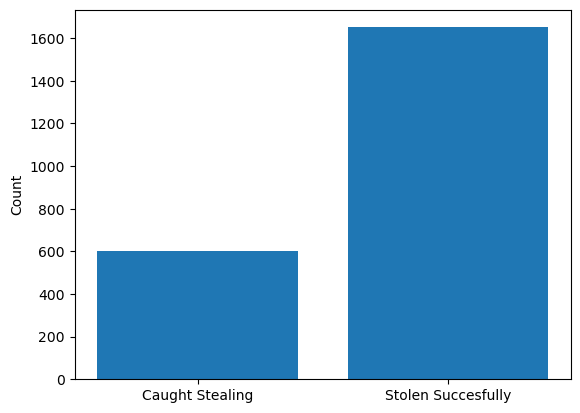

In [1186]:
plt.bar(data.groupby(['rob1_outcomeId']).count().index,data.groupby(['rob1_outcomeId']).count()['year'])
plt.xticks(ticks = [0,1],labels = ['Caught Stealing', 'Stolen Succesfully'])
plt.ylabel('Count')

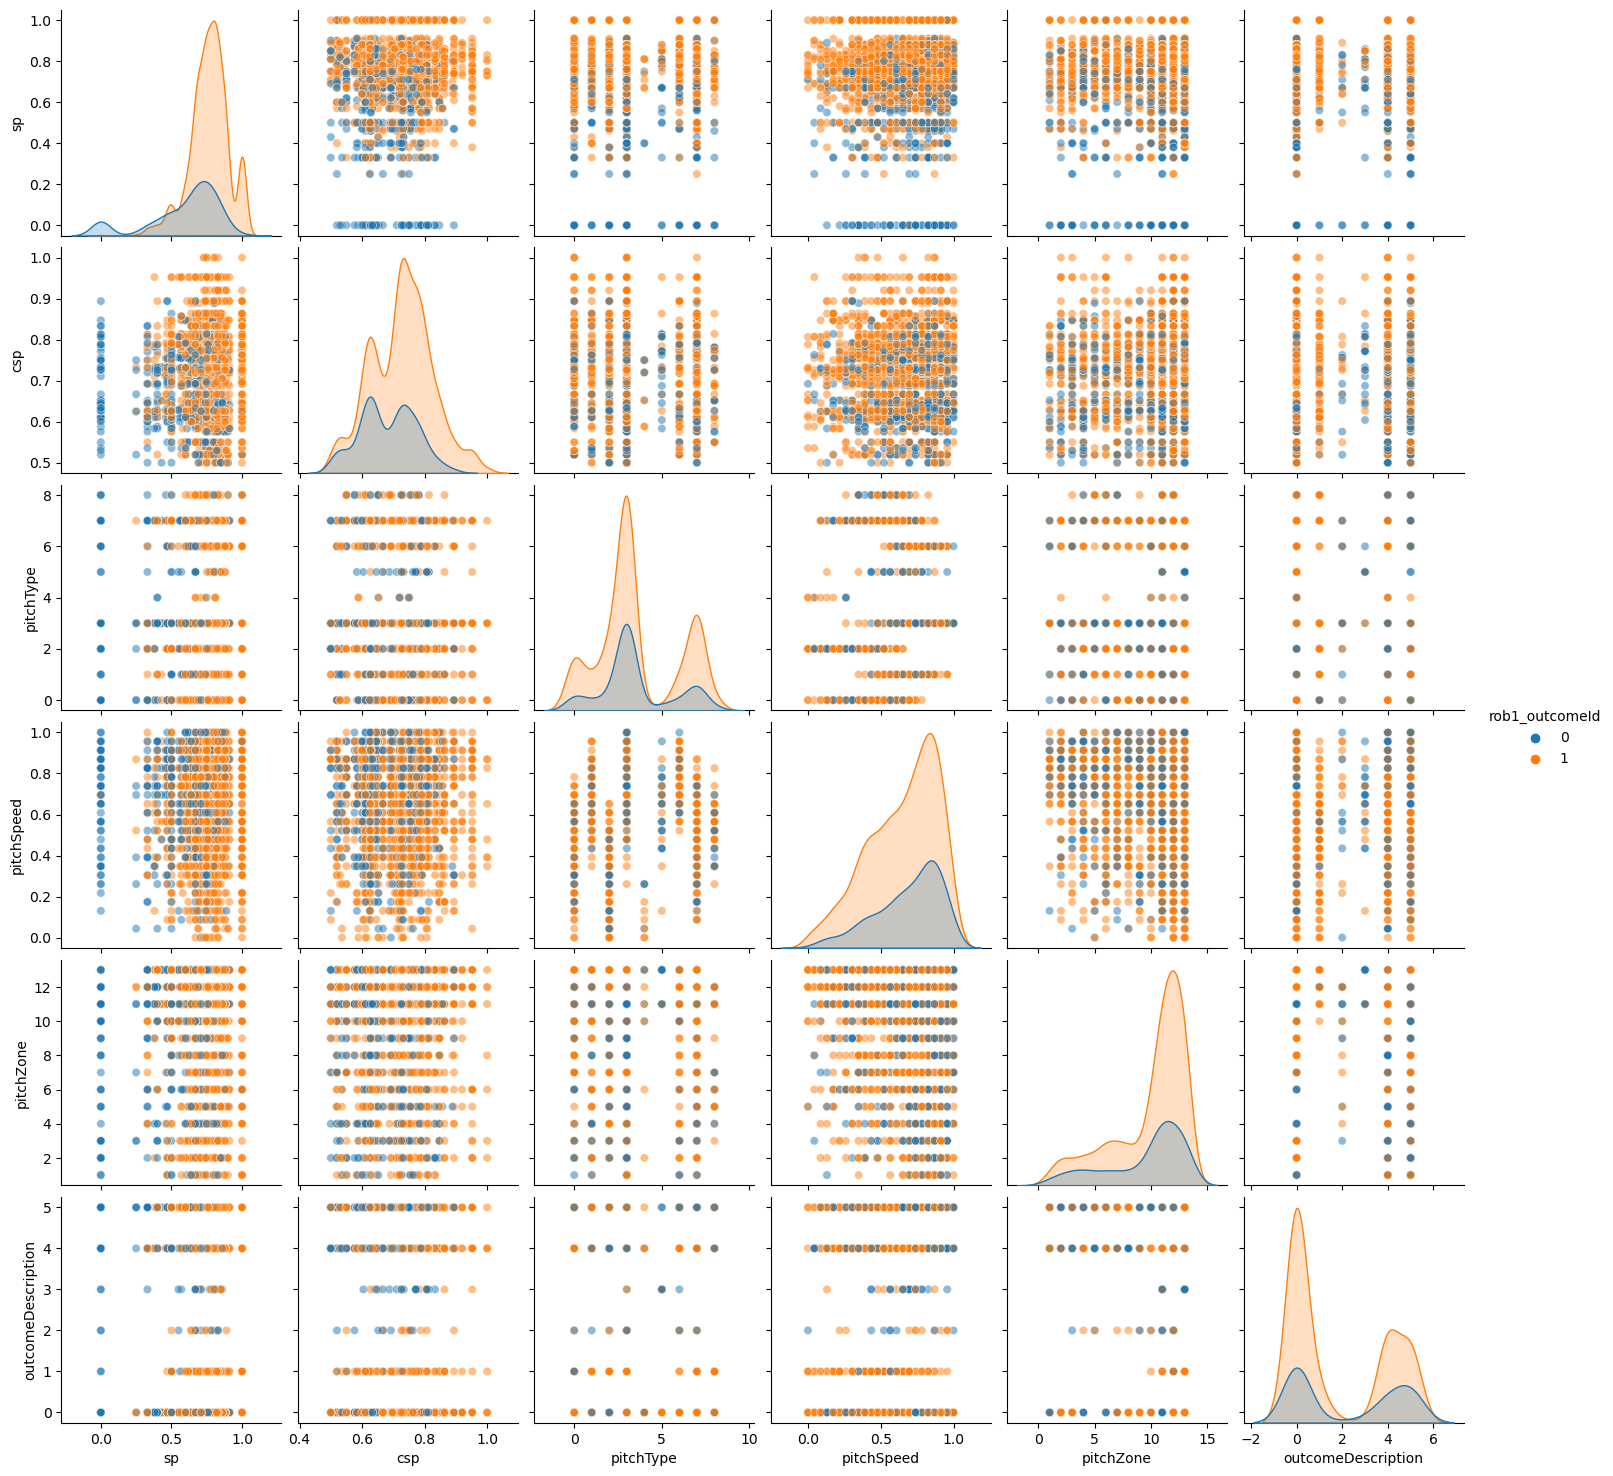

In [1187]:
import seaborn as sns
import pandas as pd

fig = sns.pairplot(encoded, hue='rob1_outcomeId', plot_kws={'alpha':0.5});

## Exploring Catcher Data

In [975]:
import matplotlib.pyplot as plt

(array([111., 111., 465., 251., 488., 524., 251.,  95.,  14.,  47.]),
 array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 10 artists>)

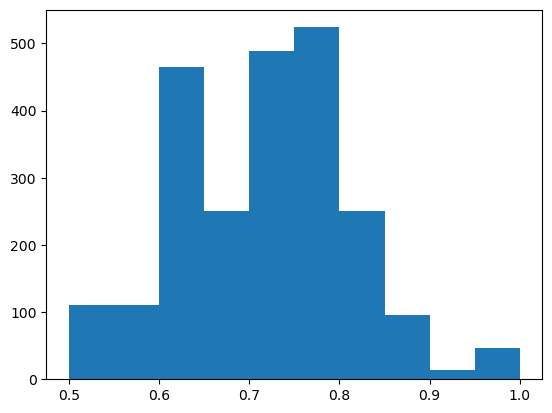

In [1177]:
plt.hist(data['csp'])

## Exploring Runner Data

(array([ 65.,   0.,   7.,  54.,  89., 201., 447., 597., 668., 229.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

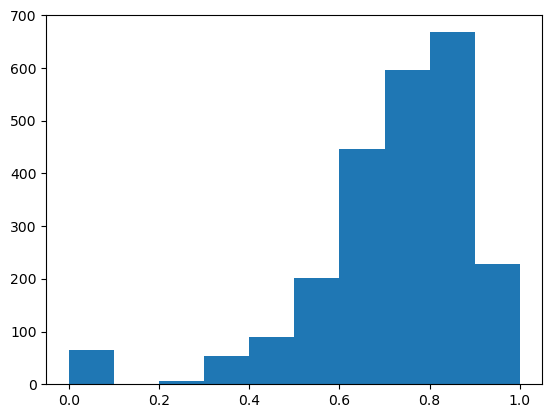

In [1178]:
plt.hist(data['sp'])

## Exploring Pitch Type Data

/var/folders/m6/z_7vpd8x7j79s4b0lm1vxb280000gn/T/ipykernel_26144/2355905075.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/var/folders/m6/z_7vpd8x7j79s4b0lm1vxb280000gn/T/ipykernel_26144/2355905075.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



<BarContainer object of 9 artists>

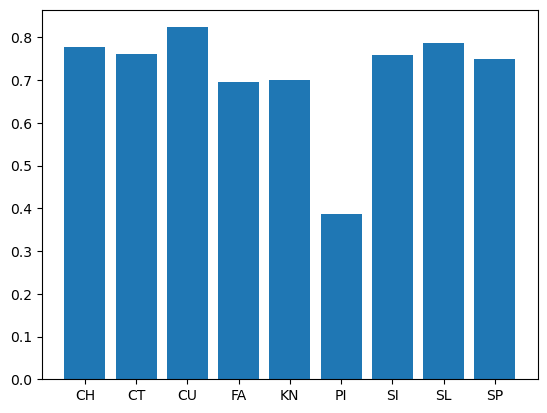

In [1180]:
plt.bar(data.groupby(['pitchType']).mean()['rob1_outcomeId'].index,data.groupby(['pitchType']).mean()['rob1_outcomeId'])

## Exploring Pitch Speed Data

/var/folders/m6/z_7vpd8x7j79s4b0lm1vxb280000gn/T/ipykernel_26144/2709558481.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/var/folders/m6/z_7vpd8x7j79s4b0lm1vxb280000gn/T/ipykernel_26144/2709558481.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



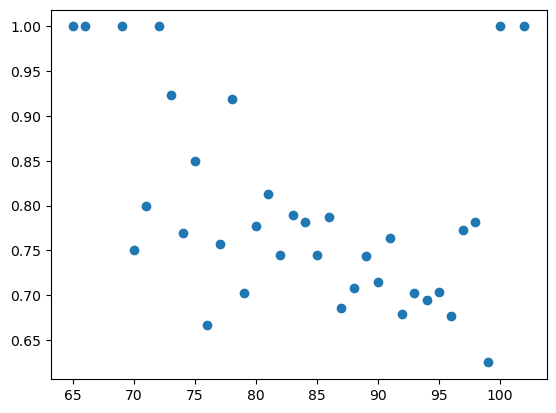

In [1181]:
plt.scatter(data.groupby(['pitchSpeed']).mean()['rob1_outcomeId'].index,data.groupby(['pitchSpeed']).mean()['rob1_outcomeId'])

In [1182]:
data = data[(data['pitchSpeed'] > 72) & (data['pitchSpeed'] < 97)]

/var/folders/m6/z_7vpd8x7j79s4b0lm1vxb280000gn/T/ipykernel_26144/2709558481.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/var/folders/m6/z_7vpd8x7j79s4b0lm1vxb280000gn/T/ipykernel_26144/2709558481.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



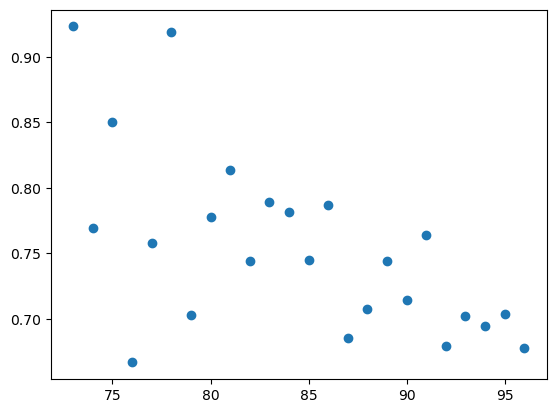

In [1183]:
plt.scatter(data.groupby(['pitchSpeed']).mean()['rob1_outcomeId'].index,data.groupby(['pitchSpeed']).mean()['rob1_outcomeId'])

##  Exploring Pitch Location

/var/folders/m6/z_7vpd8x7j79s4b0lm1vxb280000gn/T/ipykernel_26144/2412782546.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/var/folders/m6/z_7vpd8x7j79s4b0lm1vxb280000gn/T/ipykernel_26144/2412782546.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



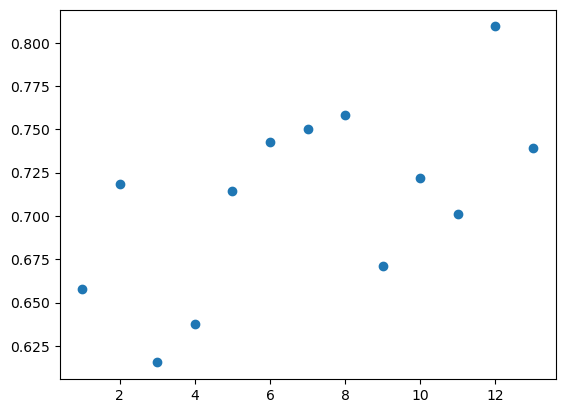

In [1184]:
plt.scatter(data.groupby(['pitchZone']).mean()['rob1_outcomeId'].index,data.groupby(['pitchZone']).mean()['rob1_outcomeId'])

## Encoding Data

In [1188]:
from sklearn.preprocessing import MinMaxScaler

In [1189]:
data.head(3)

,year,awayTeamName,homeTeamName,inningHalf,outcomeDescription,atBatEventType,hitterBatHand,pitcherThrowHand,pitcherId,pitcherFirstName,...,rob1_outcomeDescription,awayFielder2,homeFielder2,is_wild_pitch,runner,catcherID,catcher,1,sp,csp
0,2016,Indians,Blue Jays,BOT,Dirt Ball,PITCH,R,R,e3096bc2-0ed0-4783-b43a-5f1ab7d563ba,Trevor,...,Junior Lake steals second.,879db845-963e-4169-ae9c-4cd80406a322,e9fd69cd-c5df-4738-92c2-7e4ce2f4a0f4,0.0,Junior Lake,879db845-963e-4169-ae9c-4cd80406a322,Chris Gimenez,879db845-963e-4169-ae9c-4cd80406a322,1.0,0.739130
1,2016,Indians,Blue Jays,BOT,Strike Swinging,PITCH,R,R,e3096bc2-0ed0-4783-b43a-5f1ab7d563ba,Trevor,...,Kevin Pillar steals second.,879db845-963e-4169-ae9c-4cd80406a322,e9fd69cd-c5df-4738-92c2-7e4ce2f4a0f4,0.0,Kevin Pillar,879db845-963e-4169-ae9c-4cd80406a322,Chris Gimenez,879db845-963e-4169-ae9c-4cd80406a322,0.7,0.739130
2,2016,Yankees,Blue Jays,BOT,Strike Looking,PITCH,R,R,41d695be-d912-4a4f-a75f-6e1078c3362a,Dellin,...,Kevin Pillar steals second.,b8a69594-ffd7-4940-91fa-5cddeda6dd12,3da24e28-741c-4978-bdba-52de51975820,0.0,Kevin Pillar,b8a69594-ffd7-4940-91fa-5cddeda6dd12,Austin Romine,b8a69594-ffd7-4940-91fa-5cddeda6dd12,0.7,0.833333


In [1190]:
data.shape

(2251, 26)

In [1191]:
encoded =data[['rob1_outcomeId','sp','csp','pitchType','pitchSpeed','pitchZone','outcomeDescription']]

In [995]:
encoded.head(3)

,rob1_outcomeId,sp,csp,pitchType,pitchSpeed,pitchZone,outcomeDescription
0,1,1.0,0.739130,CU,78,12,Dirt Ball
1,1,0.7,0.739130,FA,95,10,Strike Swinging
2,1,0.7,0.833333,CU,84,2,Strike Looking


In [1192]:
lePT = LabelEncoder()
encoded['pitchType'] = lePT.fit_transform(encoded["pitchType"].apply(str))

/var/folders/m6/z_7vpd8x7j79s4b0lm1vxb280000gn/T/ipykernel_26144/1846496258.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1195]:
leOD = LabelEncoder()
encoded['outcomeDescription'] = leOD.fit_transform(encoded['outcomeDescription'])

/var/folders/m6/z_7vpd8x7j79s4b0lm1vxb280000gn/T/ipykernel_26144/3430286242.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1196]:
scaler = MinMaxScaler()
encoded['pitchSpeed'] = scaler.fit_transform(encoded['pitchSpeed'].array.reshape(-1, 1))

/var/folders/m6/z_7vpd8x7j79s4b0lm1vxb280000gn/T/ipykernel_26144/2280609733.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1197]:
encoded.head(3)

,rob1_outcomeId,sp,csp,pitchType,pitchSpeed,pitchZone,outcomeDescription
0,1,1.0,0.739130,2,0.217391,12,1
1,1,0.7,0.739130,3,0.956522,10,5
2,1,0.7,0.833333,2,0.478261,2,4


In [1198]:
encoded.shape

(2251, 7)

## Modeling

In [1199]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
import xgboost as xgb


In [1200]:
X = encoded.loc[:, encoded.columns != 'rob1_outcomeId']

In [1201]:
y = encoded.loc[:, encoded.columns == 'rob1_outcomeId']

In [1202]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size = .2,random_state = 23)

In [1203]:
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((1800, 6), (451, 6), (1800, 1), (451, 1))

In [1204]:
lr = LogisticRegression(max_iter = 10000, solver = 'liblinear')
lr.fit(X_train.values, Y_train['rob1_outcomeId'])
pred = lr.predict(X_test.values)

In [1207]:
"Accuracy: " + str((pred == Y_test['rob1_outcomeId']).sum()/X_test.shape[0])

'Accuracy: 0.835920177383592'

In [1208]:
"f1 Score: " + str(f1_score(pred, Y_test))

'f1 Score: 0.9021164021164022'

In [1120]:
confusion_matrix(pred, Y_test)

array([[ 36,   8],
       [ 66, 341]])

In [1209]:
"Baseline Accuracy: " + str((np.ones(X_test.shape[0]) == Y_test['rob1_outcomeId']).sum()/X_test.shape[0])

'Baseline Accuracy: 0.7738359201773836'

In [1210]:
"Baseline f1 Score: " + str(f1_score(np.ones(X_test.shape[0]),Y_test))

'Baseline f1 Score: 0.8724999999999999'

In [1211]:
weights = lr.coef_[0] * (X_train.max(axis=0) - X_train.min(axis=0)) / X_train.std(axis=0)
sorted_idx = weights.argsort()[::-1]
for i in sorted_idx:
    print(f"{X_train.columns[i]}: {weights[i]}")

sp: 23.03604967309344
csp: 14.753111556167847
pitchType: 0.005365442663381982
pitchZone: -0.08699198305169654
outcomeDescription: -0.13925893915113335
pitchSpeed: -3.9616165239916605


In [1018]:
from statistics import mean

In [1213]:
#Find Averages

percCorrect = []
f1_scores = []
baselinef1 = []
baselinepercCorrect = []
featureImp = []


for i in range(0,300):
    
    X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size = .2,random_state = i)
    
    
    
    lr = LogisticRegression(max_iter = 10000,random_state = 42,solver = 'liblinear')
    lr.fit(X_train, Y_train['rob1_outcomeId'])
    pred = lr.predict(X_test)
    
    percCorrect.append(((pred == Y_test['rob1_outcomeId']).sum()/X_test.shape[0]))
    f1_scores.append([f1_score(pred, Y_test),i])
    
    baselinef1.append(f1_score(np.ones(X_test.shape[0]),Y_test))
    baselinepercCorrect.append((np.ones(X_test.shape[0]) == Y_test['rob1_outcomeId']).sum()/X_test.shape[0])

In [1214]:
"Mean Accuracy: " +  str(mean(percCorrect))

'Mean Accuracy: 0.7791204730229121'

In [1215]:
"Baseline Mean Accuracy: " + str(mean(baselinepercCorrect))

'Baseline Mean Accuracy: 0.7329416112342941'

In [1216]:
"Mean f1: " + str(mean(pd.DataFrame(f1_scores)[0]))

'Mean f1: 0.8651017307694119'

In [1217]:
"Baseline Mean f1: " + str(mean(baselinef1))

'Baseline Mean f1: 0.8457764032084961'

In [1218]:
"Max f1: " + str(max(f1_scores)[0])

'Max f1: 0.9021164021164022'

In [1219]:
"Max accuracy: " + str(max(percCorrect))

'Max accuracy: 0.835920177383592'

## For App

In [1022]:
import pickle
pkInfo = {"model": lr, "le_pitchType": lePT, "le_OutcomeDescription": leOD, "MinMaxScaler" : scaler }
with open('savedsteps.pkl','wb') as file:
    pickle.dump(pkInfo, file)
    
    

In [130]:
with open('savedsteps.pkl','rb') as file:
        modelz  = pickle.load(file)

In [143]:
f1_score(modelz['model'].predict(X_test),Y_test)

0.9021164021164022